# IMPORTS

In [1]:
import os
import math
import time
import torch
import random
import warnings
import numpy as np
import pandas as pd
import torch.nn as nn
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, f1_score, classification_report
from accelerate import Accelerator, notebook_launcher
from torch.multiprocessing import Manager
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, BertPreTrainedModel, BertConfig, BertForSequenceClassification

# SETUP

In [2]:
warnings.filterwarnings('ignore')

In [3]:
if os.path.exists('/kaggle/working/results') == False:
    os.mkdir('/kaggle/working/results')

if os.path.exists('/kaggle/working/acquired_data') == False:
    os.mkdir('/kaggle/working/acquired_data')

In [4]:
def set_seed(seed):
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic=True
    torch.backends.cudnn.benchmark=False

# GLOBAL VARIABLES

In [5]:
manager = Manager()

# Shared resources
accuracies = manager.list()
f1_micros = manager.list()
f1_macros = manager.list()
data_used = manager.list()
sampling_dur = manager.list()
new_samples = manager.list()

# Non shared resources
filename = 'dat-kmeans'
epochs = 10
batch_size = 4
sequence_length = 192

# LOAD AND PREPROCESS DATA

In [6]:
data = pd.read_csv('/kaggle/input/doctors-answer-dataset/Indo-Online Health Consultation-Medical Interview-Clean.csv', encoding='latin-1')
data.head()

,No,answer,1-FR,2-GI,3-PI,4-DM,5-EDTRB,6-RE,Text_Clean,filtered_text,token,tokens_stemmed,Process_Data
0,1,"Halo Rizal,Radang tenggorokan umunya disebabka...",1,0,1,1,1,0,halo rizal radang tenggorokan umunya disebabka...,halo rizal radang tenggorokan umunya disebabka...,"['halo', 'rizal', 'radang', 'tenggorokan', 'um...","['halo', 'rizal', 'radang', 'tenggorok', 'umu'...",halo rizal radang tenggorok umu sebab infeksi ...
1,2,"Halo Hellas,Cacar air merupakan suatu penyakit...",1,0,1,1,1,0,halo hellas cacar air merupakan suatu penyakit...,halo hellas cacar air penyakit disebabkan viru...,"['halo', 'hellas', 'cacar', 'air', 'penyakit',...","['halo', 'hellas', 'cacar', 'air', 'sakit', 's...",halo hellas cacar air sakit sebab virus varise...
2,3,Halo Rory.......Terimakasih atas pertanyaan An...,1,0,1,1,1,0,halo rory terimakasih atas pertanyaan anda per...,halo rory terimakasih ketahui gangguan kulit s...,"['halo', 'rory', 'terimakasih', 'ketahui', 'ga...","['halo', 'rory', 'terimakasih', 'tahu', 'gangg...",halo rory terimakasih tahu ganggu kulit rangka...
3,4,"Alo AfriYani, Terimakasih atas pertanyaannya. ...",1,0,1,1,1,0,alo afriyani terimakasih atas pertanyaannya ku...,alo afriyani terimakasih pertanyaannya kuku ja...,"['alo', 'afriyani', 'terimakasih', 'pertanyaan...","['alo', 'afriyani', 'terimakasih', 'tanya', 'k...",alo afriyani terimakasih tanya kuku jari kaki ...
4,5,"Halo,Telinga berdenging atau tinitus merupak...",1,0,1,1,1,0,halo telinga berdenging atau tinitus merupakan...,halo telinga berdenging tinitus sensasi penden...,"['halo', 'telinga', 'berdenging', 'tinitus', '...","['halo', 'telinga', 'denging', 'tinitus', 'sen...",halo telinga denging tinitus sensasi dengar de...


In [7]:
train_data, val_data = train_test_split(data, test_size=0.2, random_state=42)

train_labels = train_data.columns[2:8]
val_labels = val_data.columns[2:8]
# Extract features and labels for training and validation
X_train = train_data['Text_Clean'].values
y_train = train_data[train_labels].values
X_val = val_data['Text_Clean'].values
y_val = val_data[val_labels].values

print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)

(400,) (400, 6)
(100,) (100, 6)


# BUILD DATASET & DATALOADERS

In [8]:
class DoctorAnswerDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length=256, use_float=True):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        labels = self.labels[idx]
        encoding = self.tokenizer(text, truncation=True, padding='max_length', max_length=self.max_length, return_tensors='pt')
        item = {key: val.squeeze() for key, val in encoding.items()}
        item['labels'] = torch.tensor(labels, dtype=torch.float)
        return item

# Initialize BERT tokenizer and model
tokenizer = BertTokenizer.from_pretrained('indobenchmark/indobert-base-p2')

tokenizer_config.json:   0%|          | 0.00/2.00 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/229k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

In [9]:
def get_dataloaders(X_train, y_train, X_val, y_val, sequence_length=256, num_workers=4):
    train_dataset = DoctorAnswerDataset(X_train, y_train, tokenizer, max_length=sequence_length)
    val_dataset = DoctorAnswerDataset(X_val, y_val, tokenizer, max_length=sequence_length)
    train_loader = torch.utils.data.DataLoader(
        train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=num_workers
    )
    val_loader = torch.utils.data.DataLoader(
        val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True, num_workers=num_workers
    )

    return train_loader, val_loader

# TRAIN THE MODEL

In [10]:
total_data = len(X_train) + len(X_val)
initial_train_size = int(0.05 * total_data)
checkpoints = [
    int(0.5 * total_data), 
    int(0.6 * total_data), 
    int(0.7 * total_data),
    len(X_train)
]
min_increment = 10

In [11]:
def compute_metrics(p):
    preds = torch.tensor(p.predictions) # Sigmoid and threshold for multi-label
    labels = torch.tensor(p.label_ids)

    # Hamming accuracy: proportion of correctly predicted labels over total labels
    accuracy = (preds == labels).float().mean().item()

    # Standard multi-label precision, recall, and F1 metrics
    precision, recall, f1_micro, _ = precision_recall_fscore_support(labels, preds, average='micro', zero_division=0)
    _, _, f1_macro, _ = precision_recall_fscore_support(labels, preds, average='macro', zero_division=0)

    report = classification_report(
        labels, 
        preds, 
        target_names=['1-FR', '2-GI', '3-PI', '4-DM', '5-EDTRB', '6-RE'],
        zero_division=0
    )  

    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_micro': f1_micro,
        'f1_macro': f1_macro,
        'report': report
    }

In [12]:
def train_model(current_train_size, train_indices, metrics, trials, seed):
    accelerator = Accelerator(mixed_precision='fp16')  # Initialize the accelerator
    device = accelerator.device

    accelerator.print(accelerator.distributed_type)

    with accelerator.main_process_first():
        model = BertForSequenceClassification.from_pretrained(
            'indobenchmark/indobert-base-p2',
            num_labels=len(train_labels),
            problem_type="multi_label_classification"
        )

    # Freeze the first few layers of the encoder
    for name, param in model.named_parameters():
        if "encoder.layer" in name:
            layer_num = name.split(".")[3]
            try:
                if int(layer_num) < 6:
                    param.requires_grad = False
            except ValueError:
                continue

    # Define DataLoaders
    current_X_train = [X_train[i] for i in train_indices]
    current_y_train = [y_train[i] for i in train_indices]
    train_loader, val_loader = get_dataloaders(current_X_train, current_y_train, X_val, y_val)

    # Define optimizer and loss function
    optimizer = torch.optim.AdamW(model.parameters(), lr=2e-5, weight_decay=0.01)
    loss_fn = torch.nn.BCEWithLogitsLoss()

    # Prepare everything with Accelerator
    model, optimizer, train_loader, val_loader = accelerator.prepare(
        model, optimizer, train_loader, val_loader
    )

    best_result = None
    start_time = time.time()

    for epoch in range(epochs):
        model.train()
        epoch_loss = 0

        for batch in train_loader:
            inputs = {key: val for key, val in batch.items() if key != 'labels'}
            labels = batch['labels']

            optimizer.zero_grad()
            outputs = model(**inputs)
            loss = loss_fn(outputs.logits, labels)
            accelerator.backward(loss)
            optimizer.step()

            epoch_loss += loss.item()

        # Evaluation
        model.eval()
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                inputs = {key: val for key, val in batch.items() if key != 'labels'}
                labels = batch['labels']
                
                outputs = model(**inputs)
                preds = torch.sigmoid(outputs.logits).round()

                # Gather predictions and labels from all devices
                all_preds.append(accelerator.gather(preds))
                all_labels.append(accelerator.gather(labels))

        all_preds = torch.cat(all_preds).cpu().numpy()
        all_labels = torch.cat(all_labels).cpu().numpy()

        result = compute_metrics(type('EvalOutput', (object,), {'predictions': all_preds, 'label_ids': all_labels}))

        if best_result is None or result['f1_micro'] >= best_result['f1_micro']:
            accelerator.print("Higher F1 achieved, saving model")
            
            accelerator.wait_for_everyone()
            unwrapped_model = accelerator.unwrap_model(model)
            unwrapped_model.save_pretrained(
                f'{filename}-{trials + 1}-model',
                is_main_process=accelerator.is_main_process,
                save_function=accelerator.save,
            )
            best_result = result

        accelerator.print(f"Epoch {epoch + 1}/{epochs}, Train Loss: {round(epoch_loss / len(train_loader), 4)}, Accuracy: {round(result['accuracy'], 4)}, F1 Micro: {round(result['f1_micro'], 4)}, F1 Macro: {round(result['f1_macro'], 4)}")

    end_time = time.time()
    duration = end_time - start_time
    
    accelerator.print(f"Iteration {current_train_size}: Accuracy: {round(best_result['accuracy'], 4)}, F1 Micro: {round(best_result['f1_micro'], 4)}, F1 Macro: {round(best_result['f1_macro'], 4)}")
    accelerator.print(best_result['report'])
    accelerator.print(f"Training completed in {duration} s")

    # Update the shared lists
    if accelerator.is_local_main_process:
        metrics[0].append(current_train_size)
        metrics[1].append(best_result['accuracy'])
        metrics[2].append(best_result['f1_micro'])
        metrics[3].append(best_result['f1_macro'])

# PLOT THE RESULTS

In [13]:
import matplotlib.pyplot as plt

def plot_result(data_used, accuracies, f1_micros, f1_macros):
    fig, axs = plt.subplots(1, 3, figsize=(21, 5))
    data_used = [round(data / total_data * 100, 1) for data in data_used]

    # Plot for Accuracy
    axs[0].plot(data_used, accuracies, label="Accuracy", color="blue")
    axs[0].set_xlabel("Percentage of data used")
    axs[0].set_title("Accuracy")
    axs[0].set_xticks(data_used)

    # Plot for F1 Micro
    axs[1].plot(data_used, f1_micros, label="F1 Micro", color="orange")
    axs[1].set_xlabel("Percentage of data used")
    axs[1].set_title("F1 Micro")
    axs[1].set_xticks(data_used)

    # Plot for F1 Macro
    axs[2].plot(data_used, f1_macros, label="F1 Macro", color="green")
    axs[2].set_xlabel("Percentage of data used")
    axs[2].set_title("F1 Macro")
    axs[2].set_xticks(data_used)

    # Adjust layout and show the plots
    plt.tight_layout()
    plt.show()

# QUERY STRATEGY

In [14]:
def kmeans_clustering_sampling(model, X_pool, train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, trials, n_clusters=min_increment):
    accelerator = Accelerator(mixed_precision="fp16")
    device = accelerator.device

    model.to(device)

    current_train_size = len(train_indices)
    dataset = DoctorAnswerDataset(X_pool, np.zeros((len(X_pool), 6)), tokenizer, max_length=sequence_length)
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        num_workers=4,
        pin_memory=True,
    )

    model.eval()
    start_time = time.time()
    embeddings = []
    
    with torch.no_grad():
        for data in dataloader:
            input_ids = data['input_ids'].to(device)
            attention_mask = data['attention_mask'].to(device)
            outputs = model.base_model(input_ids=input_ids, attention_mask=attention_mask)
            hidden_states = outputs.last_hidden_state.mean(dim=1)  # Mean of hidden states for vector representation
            embeddings.append(hidden_states.cpu().numpy())
    
    # Convert embeddings list to numpy array
    embeddings = np.vstack(embeddings)
    embeddings = np.array(embeddings)
    
    collected_indices = set()  # Initialize set to store selected indices
    thresholds = []

    accelerator.wait_for_everyone()

    if accelerator.is_local_main_process:
        target_samples = len(embeddings[:math.ceil(0.1 * len(embeddings))])
    
        # Check nearest checkpoint
        nearest_cp = 0
        arrived_at_cp = False
        for cp in checkpoints:
            if cp > current_train_size:
                nearest_cp = cp
                break
                
        # Determine number of maximum samples to be acquired
        if target_samples <= n_clusters and n_clusters < nearest_cp - current_train_size:
            target_samples = n_clusters
        elif target_samples > n_clusters and target_samples < nearest_cp - current_train_size:
            target_samples = target_samples
        else:
            arrived_at_cp = True
            target_samples = nearest_cp - current_train_size


        # No clustering needed when there's little data left
        if current_train_size >= checkpoints[len(checkpoints)-1] - min_increment:
            end_time = time.time()
            duration = end_time - start_time
            
            temp = train_indices.copy()
            temp.extend(remaining_indices)
            
            # Save acquired data up to checkpoint
            acquired_data = pd.DataFrame({
                'processed_text': [X_train[i] for i in temp],
                '1-FR': [y_train[i][0] for i in temp],
                '2-GI': [y_train[i][1] for i in temp],
                '3-PI': [y_train[i][2] for i in temp],
                '4-DM': [y_train[i][3] for i in temp],
                '5-EDTRB': [y_train[i][4] for i in temp],
                '6-RE': [y_train[i][5] for i in temp],
            })
            acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)

            print("Nearest checkpoint:", nearest_cp)
            print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(remaining_indices))
            print(f"Sampling duration: {duration} seconds")
            
            sampling_dur.append(duration)
            for i in remaining_indices:
                new_samples.append(i)
        else:
            # Cluster the data based on its embeddings
            kmeans=KMeans(n_clusters=n_clusters, n_init=1)
            kmeans.fit(embeddings)
            
            for cluster_id in range(n_clusters):
                # Cluster center and indices of samples in the current cluster
                cluster_center = kmeans.cluster_centers_[cluster_id]
                cluster_indices = np.where(kmeans.labels_ == cluster_id)[0]
            
                if cluster_indices.size == 0:
                    # Skip clusters with no members
                    print(f"Cluster {cluster_id} has no members, skipping.")
                    continue
            
                # Calculate distances of each point in the cluster from the cluster center
                cluster_distances = np.linalg.norm(embeddings[cluster_indices] - cluster_center, axis=1)
            
                # Determine the local threshold (10th percentile of closest distances to cluster center)
                local_threshold = np.percentile(cluster_distances, 10)
                thresholds.append(local_threshold)
            
                below_threshold_indices = cluster_indices[cluster_distances <= local_threshold]
                collected_indices.update(below_threshold_indices)

            # To handle multiple points with same distance
            if len(collected_indices) > target_samples:
                collected_indices = np.array(list(collected_indices))
                np.random.shuffle(collected_indices)
                collected_indices = collected_indices[:target_samples]
                
            end_time = time.time() 
            duration = end_time - start_time 
    
            if arrived_at_cp:
                temp = train_indices.copy()
                temp.extend(collected_indices)
                
                # Save acquired data up to checkpoint
                acquired_data = pd.DataFrame({
                    'processed_text': [X_train[i] for i in temp],
                    '1-FR': [y_train[i][0] for i in temp],
                    '2-GI': [y_train[i][1] for i in temp],
                    '3-PI': [y_train[i][2] for i in temp],
                    '4-DM': [y_train[i][3] for i in temp],
                    '5-EDTRB': [y_train[i][4] for i in temp],
                    '6-RE': [y_train[i][5] for i in temp],
                })
        
                acquired_data.to_csv(f'acquired_data/{filename}-{trials+1}-data-{nearest_cp}.csv', index=False)
            
            print("Nearest checkpoint:", nearest_cp)
            print(f"Thresholds: {thresholds}")
            print("Acquired samples:", len(collected_indices))
            print(f"Sampling duration: {duration} seconds")
        
            sampling_dur.append(duration)
            for i in collected_indices:
                new_samples.append(remaining_indices[i])

# MAIN LOOP

In [15]:
def active_learning(seed, i):
    accuracies = manager.list()
    f1_micros = manager.list()
    f1_macros = manager.list()
    data_used = manager.list()
    sampling_dur = manager.list()
    new_samples = manager.list()

    set_seed(seed)
    
    print("===============================================")
    print("TRIAL {}".format(i+1))
    print("Random seed:", seed)
    
    train_indices = np.random.choice(range(len(X_train)), initial_train_size, replace=False).tolist()
    remaining_indices = list(set(range(len(X_train))) - set(train_indices))
    
    current_train_size = initial_train_size
    
    start_time = time.time()
    while current_train_size < checkpoints[len(checkpoints) - 1]:
        # Train the model
        args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
        notebook_launcher(train_model, args, num_processes=2)
        
        model = BertForSequenceClassification.from_pretrained(f'{filename}-{i + 1}-model')
    
        # Perform query strategy to select new samples
        new_samples = manager.list()
        sampling_args = (model, [X_train[i] for i in remaining_indices], train_indices, remaining_indices, tokenizer, sampling_dur, new_samples, i)
        notebook_launcher(kmeans_clustering_sampling, sampling_args, num_processes=2)
        new_samples = list(new_samples)
        train_indices.extend(new_samples)
        remaining_indices = list(set(remaining_indices) - set(new_samples))
    
        # Update current training size
        current_train_size = len(train_indices)
        print("New train size: {}".format(current_train_size))
    
    # Train last epoch
    args = (current_train_size, train_indices, (data_used, accuracies, f1_micros, f1_macros), i, seed)
    notebook_launcher(train_model, args, num_processes=2)
    data_used, accuracies, f1_micros, f1_macros, sampling_dur = list(data_used), list(accuracies), list(f1_micros), list(f1_macros), list(sampling_dur)
    
    end_time = time.time()
    duration = end_time - start_time
    
    print(f"Total sampling time: {np.array(sampling_dur).sum().round(2)} seconds")
    print(f"Total runtime: {duration} seconds")
    
    plot_result(data_used, accuracies, f1_micros, f1_macros)
    
    results = pd.DataFrame({
        'Data Used': data_used,
        'Accuracy': accuracies,
        'F1 Micro': f1_micros,
        'F1 Macro': f1_macros,
    })
    
    sampling_dur.insert(0, 0)
    results['Sampling Duration'] = sampling_dur
    results.to_csv(f'results/{filename}-{i+1}-results.csv', index=False)

In [16]:
seeds = [50, 81, 14, 3, 94]

## RUN 1

TRIAL 1
Random seed: 50
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


pytorch_model.bin:   0%|          | 0.00/498M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6058, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3646, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.247, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.158, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1581, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1981, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1071, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0781, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4701, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2082, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.14, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.105, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1421, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1234, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1144, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1101, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4025, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1998, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.135, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1308, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1541, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1033, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1001, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0964, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.373, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1548, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1606, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1543, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1142, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1109, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0958, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0916, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3251, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1745, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1412, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1243, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1248, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1112, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1216, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 8/10, Train Loss: 0.0995, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 9/10, Train Loss: 0.0872, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.315, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1609, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.168, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1283, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1167, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1073, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 7/10, Train Loss: 0.0994, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0735, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0655, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7219
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3096, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1555, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.132, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1285, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0911, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.105, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 7/10, Train Loss: 0.0816, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.6538
Epoch 8/10, Train Loss: 0.0754, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7091
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0618, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7502
Higher 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3127, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1453, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1609, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.125, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1246, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.101, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 7/10, Train Loss: 0.0974, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6561
Epoch 8/10, Train Loss: 0.0709, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0626, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7386
Higher F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.266, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1608, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1619, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1345, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1304, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0944, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 7/10, Train Loss: 0.0905, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7543
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0744, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0453, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7664
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2768, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1549, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1335, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1064, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.101, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0855, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7511
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0656, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7998
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 10/10, Train Loss: 0.0325, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2698, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1415, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.143, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1311, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1171, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0924, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7488
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0634, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7794
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0514, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2533, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1433, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1227, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1156, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7671
Epoch 7/10, Train Loss: 0.0649, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0531, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0447, Accuracy: 0.9744, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2555, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1605, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1379, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1211, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.6543
Epoch 5/10, Train Loss: 0.0973, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 6/10, Train Loss: 0.073, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.744
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0631, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0456, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0318, Accuracy: 0.9631, F1 Micro: 0.9722, F1 Macro: 0.7377
Epoch 10/10, Train Loss: 0.0295, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2471, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1166, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1388, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1233, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1047, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7958
Epoch 6/10, Train Loss: 0.0796, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.743
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0576, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0373, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2513, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.154, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1442, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1223, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6536
Epoch 5/10, Train Loss: 0.0888, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7529
Epoch 6/10, Train Loss: 0.0636, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0529, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7458
Epoch 8/10, Train Loss: 0.0275, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7394
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0353, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0243, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2404, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.154, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1505, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.117, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0911, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7212
Epoch 6/10, Train Loss: 0.0726, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7748
Epoch 7/10, Train Loss: 0.0469, Accuracy: 0.9615, F1 Micro: 0.9711, F1 Macro: 0.7386
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0368, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Epoch 9/10, Train Loss: 0.0277, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2366, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1561, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1531, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.133, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0986, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7801
Epoch 6/10, Train Loss: 0.0705, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7663
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0578, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0387, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7544
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.253, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1554, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1427, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1118, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7647
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0921, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.747
Epoch 6/10, Train Loss: 0.0666, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7394
Epoch 7/10, Train Loss: 0.051, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7647
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0407, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7552
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.027, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2617, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.149, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1568, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1434, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.652
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1039, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Epoch 6/10, Train Loss: 0.0761, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.778
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0472, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7773
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0427, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7893
Epoch 9/10, Train Loss: 0.0306, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2467, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1581, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1639, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1238, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7974
Epoch 5/10, Train Loss: 0.0917, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0721, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.754
Epoch 7/10, Train Loss: 0.0533, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7552
Epoch 8/10, Train Loss: 0.0379, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7561
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7574
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0217, Accuracy: 0.9728, F1 Micro: 0.9793, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2455, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1671, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1419, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1093, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7648
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1049, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7545
Epoch 6/10, Train Loss: 0.0622, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7632
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0512, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.0371, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.733
Epoch 9/10, Train Loss: 0.0285, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7393
Epoch 10/10, Train Loss: 0.0211, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2307, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1529, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1355, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1143, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0682, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 6/10, Train Loss: 0.0524, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7513
Epoch 7/10, Train Loss: 0.0336, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7543
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0426, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0306, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7594
Epoch 10/10, Train Loss: 0.0223, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2499, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1511, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1565, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1186, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 5/10, Train Loss: 0.0781, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 6/10, Train Loss: 0.0582, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7745
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.046, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.8215
Epoch 8/10, Train Loss: 0.0371, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7884
Epoch 9/10, Train Loss: 0.0283, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7772
Epoch 10/10, Train Loss: 0.0232, Accuracy: 0.9631, F1 Micro: 0.9721, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2402, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1652, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1699, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1244, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7227
Epoch 5/10, Train Loss: 0.0937, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7655
Epoch 6/10, Train Loss: 0.0707, Accuracy: 0.9599, F1 Micro: 0.9695, F1 Macro: 0.7354
Epoch 7/10, Train Loss: 0.0432, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7505
Epoch 8/10, Train Loss: 0.0456, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.7772
Epoch 9/10, Train Loss: 0.0337, Accuracy: 0.9615, F1 Micro: 0.9711, F1 Macro: 0.7386
Epoch 10/10, Train Loss: 0.0206, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7384
Iteration 400: Acc

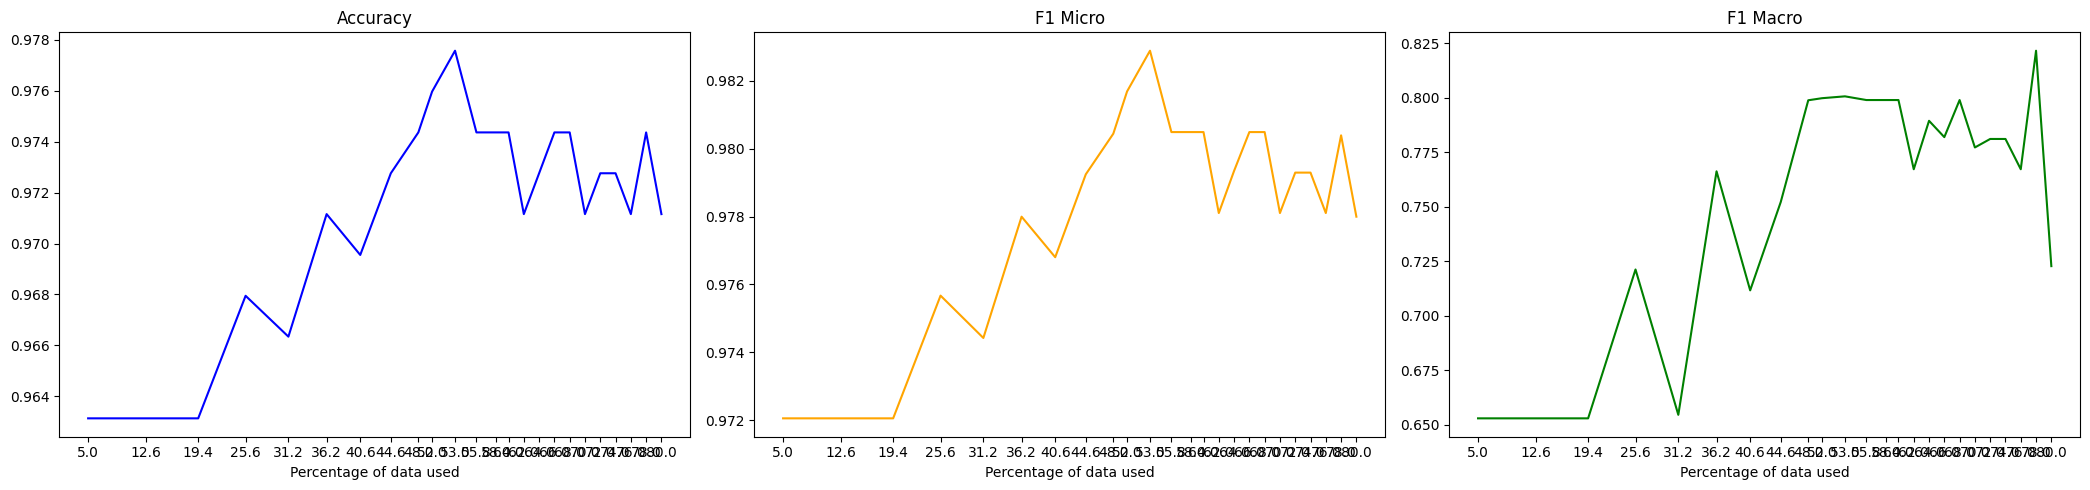

In [17]:
active_learning(seeds[0], 0)

## RUN 2

TRIAL 2
Random seed: 81
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.6264, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3387, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2128, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2886, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1748, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1776, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1499, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1805, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.498, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.251, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1815, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1419, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.154, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1101, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.092, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1059, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3829, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2038, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1247, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1569, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1452, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.127, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1526, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.089, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3852, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2034, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.14, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1512, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.133, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1168, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0977, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1171, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3453, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.17, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1549, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1386, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1136, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 6/10, Train Loss: 0.1326, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 7/10, Train Loss: 0.1047, Accuracy: 0.9631, F1 Micro: 0.9717, F1 Macro: 0.6522
Epoch 8/10, Train Loss: 0.075, Accuracy: 0.9663, F1 Micro: 0.9743, F1 Macro: 0.72
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0594, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7211
Epoch 10/10, Train Loss: 0.0382, Accuracy:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2991, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.156, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1411, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1254, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1311, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0925, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7211
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0575, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7655
Epoch 8/10, Train Loss: 0.0541, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7496
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0429, Accuracy: 0.9696, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2988, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1703, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1505, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1524, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1425, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 6/10, Train Loss: 0.1141, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7453
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0706, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.7958
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0657, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7663
Epoch 9/10, Train Loss: 0.0477, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
High

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2939, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1495, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1709, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1387, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1213, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0826, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0656, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Epoch 8/10, Train Loss: 0.0488, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7971
Epoch 9/10, Train Loss: 0.0321, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7756
Epoch 10/10, Train Loss: 0.0278, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2883, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.176, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1358, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1436, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 5/10, Train Loss: 0.1204, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.077, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Epoch 7/10, Train Loss: 0.0595, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7579
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0577, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Epoch 9/10, Train Loss: 0.0428, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 10/

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.274, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1658, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1446, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1309, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1104, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7795
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0762, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7663
Epoch 7/10, Train Loss: 0.0642, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 8/10, Train Loss: 0.0374, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.757
Epoch 9/10, Train Loss: 0.0349, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7876
Epoch 10/10, Train Loss: 0.0284, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2526, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1455, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1517, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1233, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.106, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.778
Epoch 6/10, Train Loss: 0.082, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7932
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0601, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7981
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0513, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0268, Accuracy: 0.9728, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2733, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1604, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1437, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1236, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.0833, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.7167
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0759, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7982
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.052, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 8/10, Train Loss: 0.0537, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7496
Epoch 9/10, Train Loss: 0.0283, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7503
Epoch 10/10, Train Loss: 0.0289, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2425, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1458, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1312, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1178, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.0903, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.753
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0694, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7228
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0623, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.0476, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Epoch 9/10, Train Loss: 0.0286, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 10/10, Train Loss: 0.0254, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2622, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1654, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1469, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1144, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7208
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0786, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Epoch 6/10, Train Loss: 0.0835, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7471
Epoch 7/10, Train Loss: 0.0523, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7393
Epoch 8/10, Train Loss: 0.0381, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0303, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2653, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1556, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1404, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1256, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.0989, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.761
Epoch 6/10, Train Loss: 0.0648, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0515, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 8/10, Train Loss: 0.0434, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7557
Epoch 9/10, Train Loss: 0.0303, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7764
Epoch 10/10, Train Loss: 0.0216, Accuracy: 0.9712, F1 Micro: 0.978, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2644, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1521, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1374, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1282, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7673
Epoch 5/10, Train Loss: 0.0818, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7663
Epoch 6/10, Train Loss: 0.0504, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 7/10, Train Loss: 0.0423, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 8/10, Train Loss: 0.0335, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7802
Epoch 9/10, Train Loss: 0.0264, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7791
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0212, Accuracy: 0.9744, F1 Micro: 0.9805, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.26, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1502, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1304, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1121, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.8027
Epoch 5/10, Train Loss: 0.0844, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0575, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 7/10, Train Loss: 0.0417, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7493
Epoch 8/10, Train Loss: 0.0356, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7567
Epoch 9/10, Train Loss: 0.0276, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 10/10, Train Loss: 0.0218, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Ma

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2599, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1697, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1496, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 4/10, Train Loss: 0.1099, Accuracy: 0.9647, F1 Micro: 0.9735, F1 Macro: 0.7506
Epoch 5/10, Train Loss: 0.0855, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7948
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0491, Accuracy: 0.9744, F1 Micro: 0.9806, F1 Macro: 0.8043
Epoch 7/10, Train Loss: 0.0483, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8198
Epoch 8/10, Train Loss: 0.0311, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7884
Epoch 9/10, Train Loss: 0.0237, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 10/10, Train Loss: 0.0187, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Iteration 340: Acc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2491, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1601, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1469, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1432, Accuracy: 0.9615, F1 Micro: 0.9704, F1 Macro: 0.6512
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.796
Epoch 6/10, Train Loss: 0.0775, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7936
Epoch 7/10, Train Loss: 0.0491, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7585
Epoch 8/10, Train Loss: 0.0477, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.8003
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0299, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8022
Epoch 10/10, Train Loss: 0.0252, Accuracy: 0.9679, F1 Micro: 0.9755, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.255, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1732, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1477, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1097, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8022
Epoch 5/10, Train Loss: 0.0889, Accuracy: 0.9631, F1 Micro: 0.9716, F1 Macro: 0.7917
Epoch 6/10, Train Loss: 0.0536, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7458
Epoch 7/10, Train Loss: 0.0441, Accuracy: 0.9679, F1 Micro: 0.9753, F1 Macro: 0.7946
Epoch 8/10, Train Loss: 0.0439, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7539
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0283, Accuracy: 0.9728, F1 Micro: 0.9791, F1 Macro: 0.7977
Epoch 10/10, Train Loss: 0.026, Accuracy: 0.9696, F1 Micro: 0.9769, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2481, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1612, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1656, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1219, Accuracy: 0.9647, F1 Micro: 0.9729, F1 Macro: 0.7187
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0854, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 6/10, Train Loss: 0.069, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 7/10, Train Loss: 0.0485, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7874
Epoch 8/10, Train Loss: 0.0487, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8023
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0257, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.8033
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0242, Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2422, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1608, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1602, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1266, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Epoch 5/10, Train Loss: 0.0891, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0647, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7959
Epoch 7/10, Train Loss: 0.0414, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.8175
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0298, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.8215
Epoch 9/10, Train Loss: 0.0309, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7988
Epoch 10/10, Train Loss: 0.0284, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2502, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1631, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.142, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1244, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7762
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0946, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0653, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7894
Epoch 7/10, Train Loss: 0.0451, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.0381, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.8002
Epoch 9/10, Train Loss: 0.0322, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7663
Epoch 10/10, Train Loss: 0.0231, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2427, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1486, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1546, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 4/10, Train Loss: 0.1059, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.6507
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.099, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0628, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.805
Epoch 7/10, Train Loss: 0.0341, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7818
Epoch 8/10, Train Loss: 0.0341, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0263, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Epoch 10/10, Train Loss: 0.0219, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Ma

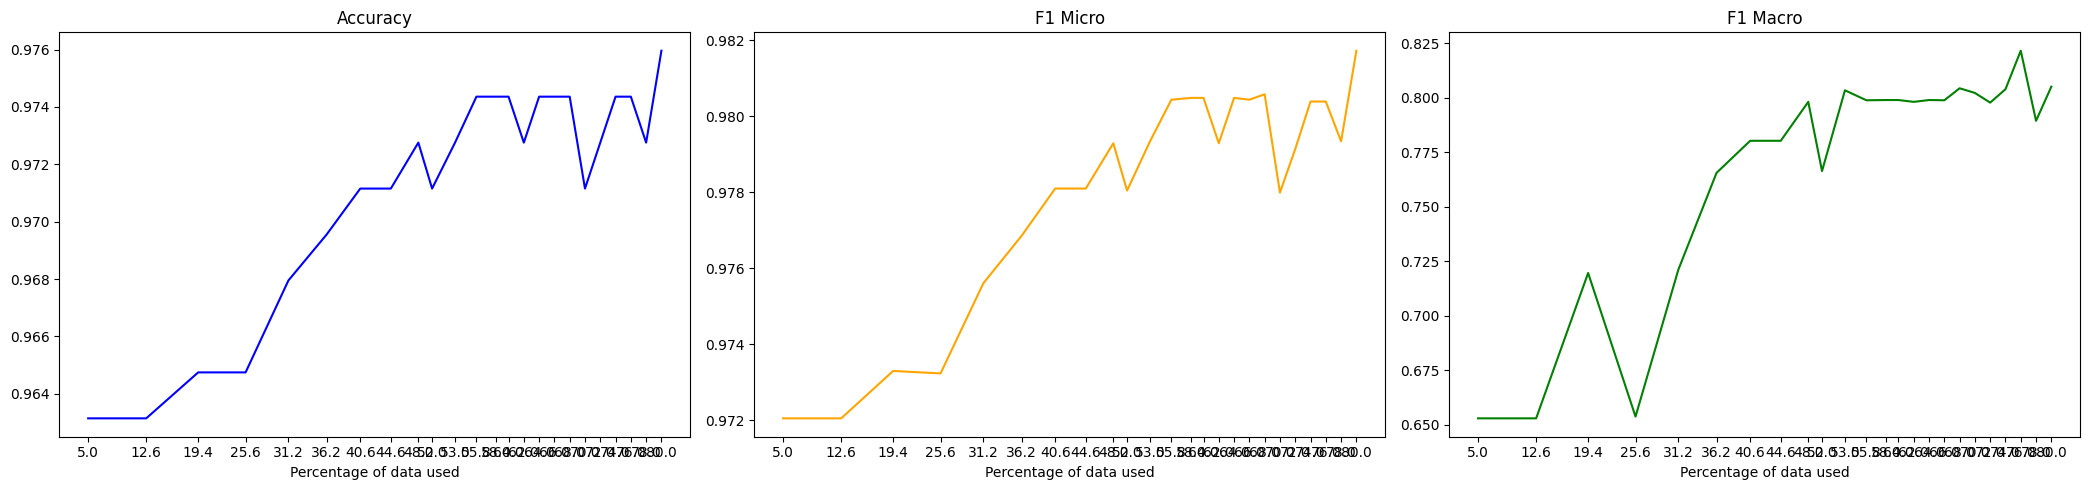

In [18]:
active_learning(seeds[1], 1)

## RUN 3

TRIAL 3
Random seed: 14
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5338, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3414, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2451, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2103, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1435, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1557, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1241, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1134, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4485, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2103, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2051, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1261, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1371, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.137, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1404, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 9/10, Train Loss: 0.0896, Accuracy: 0.9583, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3692, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.16, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1624, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1419, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0931, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.139, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.115, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0982, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3297, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1826, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1244, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1469, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1175, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1114, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.099, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0919, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 9/10, Train Loss: 0.0891, Accuracy: 0.9647, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3041, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.151, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1517, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1238, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1238, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1073, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0843, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7212
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2752, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1433, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1215, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.157, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1343, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0944, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0951, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0616, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7211
Epoch 9/10, Train Loss: 0.0461, Accuracy: 0.9647, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2679, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1557, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1711, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1352, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1297, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0939, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 7/10, Train Loss: 0.0813, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0689, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.7219
Epoch 9/10, Train Loss: 0.0385, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7648
High

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.277, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1449, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1354, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1397, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1174, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1022, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 7/10, Train Loss: 0.1035, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 8/10, Train Loss: 0.0737, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0502, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.799
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.255, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1377, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1521, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1481, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1278, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0897, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7498
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0652, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7808
Epoch 8/10, Train Loss: 0.0542, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7506
Epoch 9/10, Train Loss: 0.0404, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7795
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2555, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1556, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.152, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1462, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1159, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0831, Accuracy: 0.9696, F1 Micro: 0.9766, F1 Macro: 0.6558
Epoch 7/10, Train Loss: 0.0647, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7384
Epoch 8/10, Train Loss: 0.0589, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7212
Epoch 9/10, Train Loss: 0.0446, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7656
Higher F1 achieved, saving model
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.264, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1647, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1513, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.138, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1022, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0725, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7387
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0589, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7883
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0434, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.782
Epoch 9/10, Train Loss: 0.0337, Accuracy: 0.9744, F1 Micro: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2433, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1471, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1489, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1258, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1124, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 6/10, Train Loss: 0.0959, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.6551
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0575, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 8/10, Train Loss: 0.0521, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7673
Epoch 9/10, Train Loss: 0.0382, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 10/10, Train Loss: 0.0291, Accuracy: 0.9712, F1 Micro: 0.978, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2523, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1376, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1396, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1197, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1077, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0817, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7879
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.047, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0369, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7893
Epoch 9/10, Train Loss: 0.0399, Accuracy: 0.9712, F1 Micro:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2571, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1565, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1308, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1325, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1014, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6552
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0703, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7974
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0577, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.8034
Epoch 8/10, Train Loss: 0.0363, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0262, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.8034
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2349, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1526, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1459, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1288, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1068, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7656
Epoch 6/10, Train Loss: 0.0643, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7663
Epoch 7/10, Train Loss: 0.0552, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7549
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0435, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7802
Epoch 9/10, Train Loss: 0.0287, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 10/10, Train Loss: 0.0298, Accu

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2428, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.182, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1588, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1221, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0855, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7379
Epoch 6/10, Train Loss: 0.0806, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7374
Epoch 7/10, Train Loss: 0.0492, Accuracy: 0.9599, F1 Micro: 0.9699, F1 Macro: 0.7337
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0449, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0347, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.8218
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2418, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1533, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1467, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1286, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1073, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0691, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7887
Epoch 7/10, Train Loss: 0.043, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7501
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0346, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7893
Epoch 9/10, Train Loss: 0.0281, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2461, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1505, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1514, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1224, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 5/10, Train Loss: 0.0964, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.6539
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0723, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 7/10, Train Loss: 0.0581, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7886
Epoch 8/10, Train Loss: 0.0329, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 9/10, Train Loss: 0.0336, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7869
Epoch 10/10, Train Loss: 0.0232, Accuracy: 0.9696, F1 Micro: 0.9769, F

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2354, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1693, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1371, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.134, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0966, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7228
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0674, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.0472, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7795
Epoch 8/10, Train Loss: 0.0482, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0392, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.778
Epoch 10/10, Train Loss: 0.0225, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2311, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1512, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.148, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.118, Accuracy: 0.9583, F1 Micro: 0.9677, F1 Macro: 0.6486
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0895, Accuracy: 0.9663, F1 Micro: 0.9741, F1 Macro: 0.7767
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0619, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0513, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7978
Epoch 8/10, Train Loss: 0.0283, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7989
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Epoch 10/10, Train Loss: 0.0253, Accuracy: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2364, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1594, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.146, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1216, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0958, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7651
Epoch 6/10, Train Loss: 0.0619, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7661
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0465, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.768
Epoch 8/10, Train Loss: 0.0412, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.756
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0285, Accuracy: 0.9744, F1 Micro: 0.9804, F1 Macro: 0.7988
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2553, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1574, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1513, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1411, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 5/10, Train Loss: 0.108, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0726, Accuracy: 0.976, F1 Micro: 0.9817, F1 Macro: 0.7998
Epoch 7/10, Train Loss: 0.0518, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7762
Epoch 8/10, Train Loss: 0.0415, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Epoch 9/10, Train Loss: 0.0319, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Epoch 10/10, Train Loss: 0.0249, Accuracy: 0.9744, F1 Micro: 0.9805, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2301, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1642, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1393, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1393, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.0864, Accuracy: 0.9615, F1 Micro: 0.9702, F1 Macro: 0.7904
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0619, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7672
Epoch 7/10, Train Loss: 0.0426, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.797
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0356, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Epoch 9/10, Train Loss: 0.0288, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 10/10, Train Loss: 0.0253, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2317, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.169, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1498, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1319, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0984, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.0739, Accuracy: 0.9647, F1 Micro: 0.9728, F1 Macro: 0.7925
Epoch 7/10, Train Loss: 0.0491, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7513
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0361, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.781
Epoch 9/10, Train Loss: 0.028, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 10/

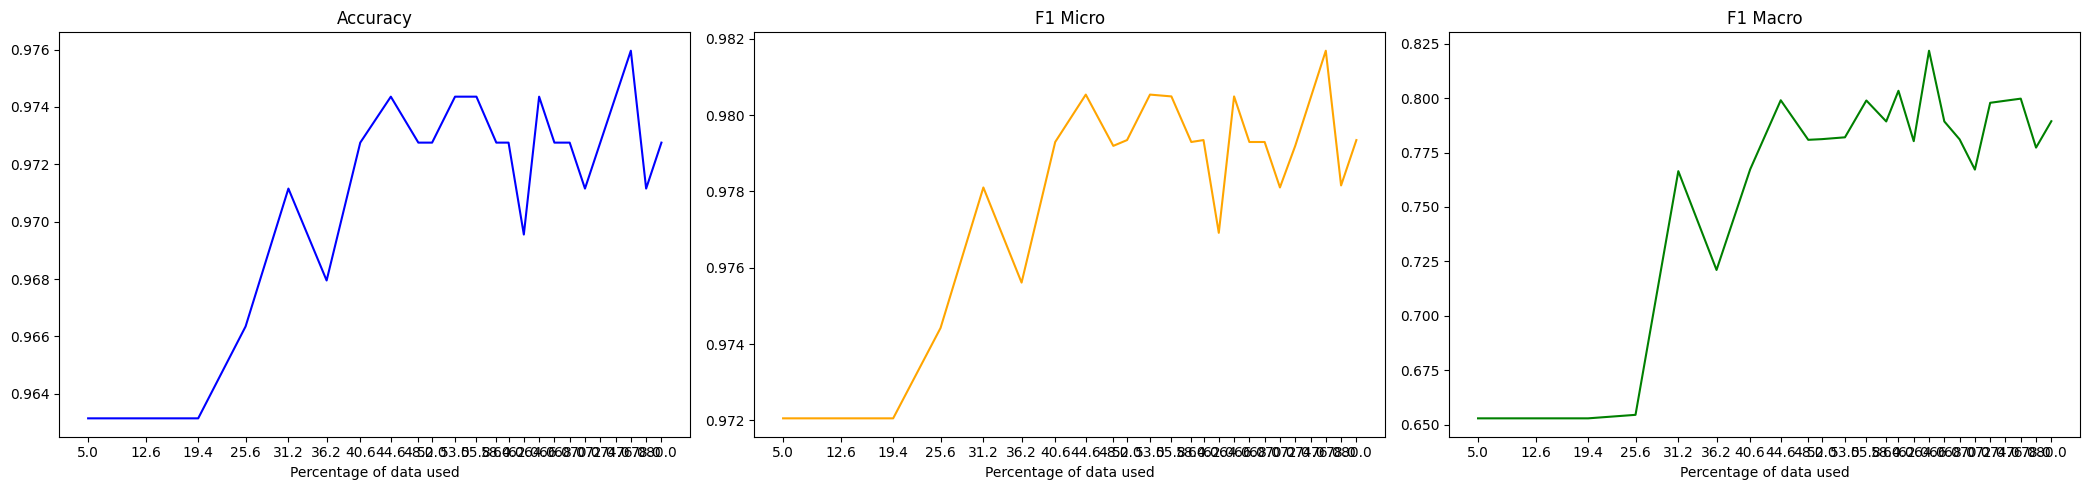

In [19]:
active_learning(seeds[2], 2)

## RUN 4

TRIAL 4
Random seed: 3
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5222, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.3348, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2357, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1843, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1554, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1788, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1769, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1621, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2018, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1706, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1413, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1436, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.147, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1624, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1101, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.325, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1305, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1076, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1157, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1153, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0687, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0962, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0906, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3023, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1554, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1265, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.109, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1303, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1219, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1129, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1145, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2986, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1707, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1365, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1284, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.143, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1303, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.0994, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0927, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6562
Epoch 9/10, Train Loss: 0.0695, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7648
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2671, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1435, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1396, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1494, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1513, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.145, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1098, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0794, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7462
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2614, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1684, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1307, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1555, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1415, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1565, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0973, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7656
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0611, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7656
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2644, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1342, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1456, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.131, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1277, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1338, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0939, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.764
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0783, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7673
Epoch 9/10, Train Loss: 0.0546, Accuracy: 0.9696, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2437, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1662, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1551, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1195, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1228, Accuracy: 0.9615, F1 Micro: 0.9711, F1 Macro: 0.7438
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0856, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7787
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0531, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0438, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7803
Epoch 9/10, Train Loss: 0.0337, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7562
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2586, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1465, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1306, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1307, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1256, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0945, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.8196
Epoch 7/10, Train Loss: 0.058, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7654
Epoch 8/10, Train Loss: 0.0408, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7663
Epoch 9/10, Train Loss: 0.0361, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7664
Epoch 10/10, Train Loss: 0.0298, Accura

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2525, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.149, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1398, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1684, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.136, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.0968, Accuracy: 0.9615, F1 Micro: 0.9711, F1 Macro: 0.737
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0618, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7673
Epoch 8/10, Train Loss: 0.0518, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7379
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.039, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7812
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2306, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1733, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1425, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1459, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1424, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 6/10, Train Loss: 0.1188, Accuracy: 0.9599, F1 Micro: 0.9699, F1 Macro: 0.7362
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0924, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7579
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0669, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7876
Epoch 9/10, Train Loss: 0.0433, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7756
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2248, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1347, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1459, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1448, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1221, Accuracy: 0.9615, F1 Micro: 0.9711, F1 Macro: 0.7438
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0901, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7648
Epoch 7/10, Train Loss: 0.0779, Accuracy: 0.9583, F1 Micro: 0.9684, F1 Macro: 0.7347
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0525, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7656
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0438, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7553
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2332, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1592, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1585, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1576, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1233, Accuracy: 0.9599, F1 Micro: 0.9699, F1 Macro: 0.7362
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0881, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7783
Epoch 7/10, Train Loss: 0.066, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7635
Epoch 8/10, Train Loss: 0.0461, Accuracy: 0.9615, F1 Micro: 0.9708, F1 Macro: 0.7523
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0289, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.8129
Epoch 10/10, Train Loss: 0.0281, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2418, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1451, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1723, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1398, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1323, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7038
Epoch 6/10, Train Loss: 0.0995, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7452
Epoch 7/10, Train Loss: 0.0573, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7635
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0544, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0358, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7673
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2361, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1655, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1495, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.134, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0985, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7865
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0837, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7673
Epoch 7/10, Train Loss: 0.0532, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7663
Epoch 8/10, Train Loss: 0.0432, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7522
Epoch 9/10, Train Loss: 0.0314, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7522
Epoch 10/10, Train Loss: 0.0184, Accur

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2391, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1741, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.151, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1356, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1087, Accuracy: 0.9503, F1 Micro: 0.9612, F1 Macro: 0.752
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0728, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7557
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0547, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7744
Epoch 8/10, Train Loss: 0.0335, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7643
Epoch 9/10, Train Loss: 0.027, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.246, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1728, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1467, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1461, Accuracy: 0.9599, F1 Micro: 0.9699, F1 Macro: 0.7362
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1163, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7803
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0692, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Epoch 7/10, Train Loss: 0.0498, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7663
Epoch 8/10, Train Loss: 0.0422, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Epoch 9/10, Train Loss: 0.0267, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0259, Accuracy: 0.9647, F1 Micro: 0.9734, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2264, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1723, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.147, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1391, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1211, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7981
Epoch 6/10, Train Loss: 0.0707, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7505
Epoch 7/10, Train Loss: 0.0546, Accuracy: 0.9631, F1 Micro: 0.9719, F1 Macro: 0.7555
Epoch 8/10, Train Loss: 0.036, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.8033
Epoch 9/10, Train Loss: 0.0256, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7644
Epoch 10/10, Train Loss: 0.0179, Accuracy: 0.9631, F1 Micro: 0.9722, F1 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2281, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.17, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1509, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1647, Accuracy: 0.9583, F1 Micro: 0.9688, F1 Macro: 0.7298
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.0962, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7496
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0743, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7544
Epoch 7/10, Train Loss: 0.0511, Accuracy: 0.9599, F1 Micro: 0.9697, F1 Macro: 0.7476
Epoch 8/10, Train Loss: 0.0426, Accuracy: 0.9615, F1 Micro: 0.971, F1 Macro: 0.7487
Epoch 9/10, Train Loss: 0.0255, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.729
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0252, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2266, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1475, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1558, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1216, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7434
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1115, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7661
Epoch 6/10, Train Loss: 0.0631, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.757
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0486, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7773
Epoch 8/10, Train Loss: 0.0316, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7513
Epoch 9/10, Train Loss: 0.0242, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7513
Epoch 10/10, Train Loss: 0.0225, Accuracy: 0.9647, F1 Micro: 0.9734, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2276, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1752, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1542, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1498, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1057, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.798
Epoch 6/10, Train Loss: 0.0697, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.764
Epoch 7/10, Train Loss: 0.0498, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.7862
Epoch 8/10, Train Loss: 0.038, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7875
Epoch 9/10, Train Loss: 0.0286, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7654
Epoch 10/10, Train Loss: 0.0243, Accuracy: 0.9679, F1 Micro: 0.9757, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2251, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.172, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1649, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 4/10, Train Loss: 0.1471, Accuracy: 0.9599, F1 Micro: 0.9699, F1 Macro: 0.7306
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.093, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7662
Epoch 6/10, Train Loss: 0.078, Accuracy: 0.9615, F1 Micro: 0.9707, F1 Macro: 0.7545
Epoch 7/10, Train Loss: 0.0525, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7522
Epoch 8/10, Train Loss: 0.0337, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7661
Epoch 9/10, Train Loss: 0.0318, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7672
Epoch 10/10, Train Loss: 0.0215, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7595
Iteration 390: Accurac

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.237, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1723, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1546, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1279, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7757
Epoch 5/10, Train Loss: 0.0848, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.7844
Epoch 6/10, Train Loss: 0.0647, Accuracy: 0.9631, F1 Micro: 0.972, F1 Macro: 0.7556
Epoch 7/10, Train Loss: 0.0499, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7566
Epoch 8/10, Train Loss: 0.0315, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7493
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0244, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Higher F1 achieved, saving model
Epoch 10/10, Train Loss: 0.0213, Accurac

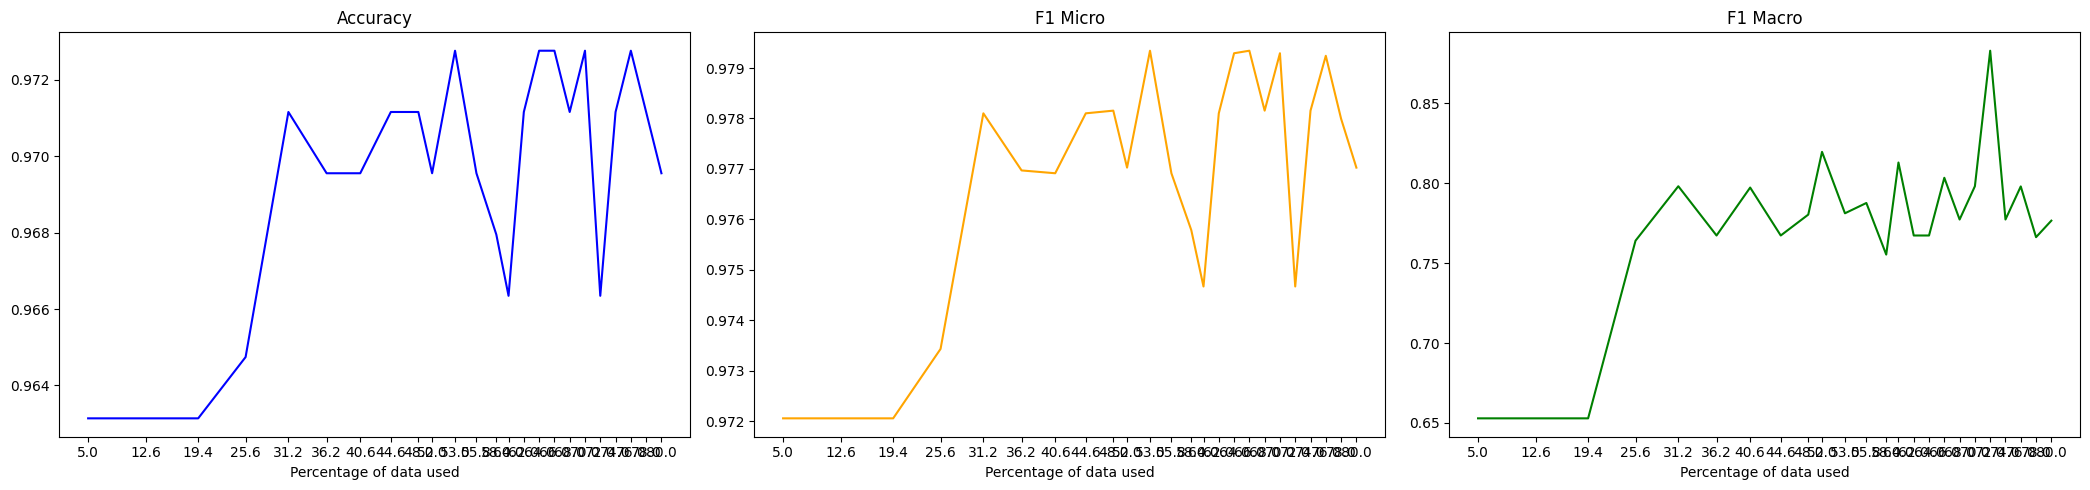

In [20]:
active_learning(seeds[3], 3)

## RUN 5

TRIAL 5
Random seed: 94
Launching training on 2 GPUs.
DistributedType.MULTI_GPU


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.5634, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.337, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.281, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2662, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.207, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.2021, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1693, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.2011, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.4446, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.2319, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.2034, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.2202, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1375, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1312, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1613, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1188, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3635, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1748, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1649, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1484, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1352, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1492, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1174, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0879, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3368, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1671, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1433, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1387, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1355, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1029, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1164, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.1108, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 9/10, Train Loss:

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.3089, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1511, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1618, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1298, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.115, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1419, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0954, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Epoch 8/10, Train Loss: 0.1096, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 9/10, Train Loss: 0.0779, Accuracy: 0.9615, F1 Micro: 0.9711, F1 Macro: 0.7438
Highe

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2717, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.167, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1621, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1281, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1528, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1514, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.1144, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 8/10, Train Loss: 0.0862, Accuracy: 0.9535, F1 Micro: 0.9654, F1 Macro: 0.7247
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0747, Accuracy: 0.9631, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2822, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1737, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1305, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1374, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1486, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.103, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 7/10, Train Loss: 0.1073, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0861, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7302
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0501, Accuracy: 0.9696, F1 Micr

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2605, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1528, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1489, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1208, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1462, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1324, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0935, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7506
Epoch 8/10, Train Loss: 0.0779, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7196
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0478, Accuracy: 0.9712, F1 Mic

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2514, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.145, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1223, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1558, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1315, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.1263, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 7/10, Train Loss: 0.0724, Accuracy: 0.9679, F1 Micro: 0.9755, F1 Macro: 0.656
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0568, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7412
Epoch 9/10, Train Loss: 0.0431, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7471
Higher F1 achieved, saving model
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2551, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1574, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1393, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1387, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1541, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1168, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7109
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0835, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7562
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0498, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.782
Epoch 9/10, Train Loss: 0.0484, Accuracy: 0.9712, F1 Micro

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.256, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1551, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1541, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1328, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1111, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 6/10, Train Loss: 0.0865, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7286
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0636, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7819
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0463, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7902
Epoch 9/10, Train Loss: 0.0346, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7587
Epoch

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2424, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1534, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1516, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1457, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.6537
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1343, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.1027, Accuracy: 0.9744, F1 Micro: 0.9805, F1 Macro: 0.7989
Epoch 7/10, Train Loss: 0.0739, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.722
Epoch 8/10, Train Loss: 0.0552, Accuracy: 0.9615, F1 Micro: 0.9709, F1 Macro: 0.7265
Epoch 9/10, Train Loss: 0.0401, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.747
Epoch 10/10, Train Loss: 0.0275, Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.244, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1781, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.169, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1182, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.657
Epoch 5/10, Train Loss: 0.1259, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 6/10, Train Loss: 0.092, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7749
Epoch 7/10, Train Loss: 0.0683, Accuracy: 0.9615, F1 Micro: 0.9711, F1 Macro: 0.7433
Epoch 8/10, Train Loss: 0.0478, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.746
Epoch 9/10, Train Loss: 0.0413, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7653
Epoch 10/10, Train Loss: 0.0323, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.7444
Iteration 292: Accuracy

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2493, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1776, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1699, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1476, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.655
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1248, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7673
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0823, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.78
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.062, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.7803
Epoch 8/10, Train Loss: 0.046, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7756
Epoch 9/10, Train Loss: 0.0345, Accuracy: 0.9567, F1 Micro: 0.9675, F1 Macro: 0.7376
Epoch 10/10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2497, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1627, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.145, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1378, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1272, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7664
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.082, Accuracy: 0.9728, F1 Micro: 0.9792, F1 Macro: 0.7672
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0621, Accuracy: 0.9728, F1 Micro: 0.9793, F1 Macro: 0.7811
Epoch 8/10, Train Loss: 0.0452, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7772
Epoch 9/10, Train Loss: 0.0341, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7585
Epoch 

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2448, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1797, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1678, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1479, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 5/10, Train Loss: 0.127, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7545
Epoch 6/10, Train Loss: 0.0596, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7503
Epoch 7/10, Train Loss: 0.0593, Accuracy: 0.9663, F1 Micro: 0.9747, F1 Macro: 0.7579
Epoch 8/10, Train Loss: 0.0452, Accuracy: 0.9583, F1 Micro: 0.9687, F1 Macro: 0.7487
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0318, Accuracy: 0.9712, F1 Micro: 0.9782, F1 Macro: 0.8025
Epoch 10/10, Train Loss: 0.0264, Accuracy: 0.9615, F1 Micro: 0.9711, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2396, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.165, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1509, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1266, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 5/10, Train Loss: 0.1165, Accuracy: 0.9663, F1 Micro: 0.974, F1 Macro: 0.7628
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0848, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7798
Epoch 7/10, Train Loss: 0.0743, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7595
Epoch 8/10, Train Loss: 0.0466, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.766
Epoch 9/10, Train Loss: 0.0345, Accuracy: 0.9631, F1 Micro: 0.9723, F1 Macro: 0.7449
Higher F1 achieved, saving model
Epoch 10

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2427, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1598, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1316, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1224, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.6569
Epoch 5/10, Train Loss: 0.1151, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7561
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0801, Accuracy: 0.9712, F1 Micro: 0.9779, F1 Macro: 0.7969
Epoch 7/10, Train Loss: 0.0545, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7765
Epoch 8/10, Train Loss: 0.0465, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7672
Epoch 9/10, Train Loss: 0.0326, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7662
Epoch 10/10, Train Loss: 0.022, Accuracy: 0.9696, F1 Micro: 0.9769, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2328, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1607, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1627, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1235, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6545
Epoch 5/10, Train Loss: 0.0908, Accuracy: 0.9471, F1 Micro: 0.9607, F1 Macro: 0.7086
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0703, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.7671
Epoch 7/10, Train Loss: 0.0536, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7585
Epoch 8/10, Train Loss: 0.0308, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7671
Epoch 9/10, Train Loss: 0.0239, Accuracy: 0.9679, F1 Micro: 0.9757, F1 Macro: 0.7662
Epoch 10/10, Train Loss: 0.0213, Accuracy: 0.9696, F1 Micro: 0.9769, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2217, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1467, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1478, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1314, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Epoch 5/10, Train Loss: 0.1088, Accuracy: 0.9599, F1 Micro: 0.9691, F1 Macro: 0.65
Higher F1 achieved, saving model
Epoch 6/10, Train Loss: 0.0894, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.7643
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0587, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7577
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0441, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7522
Epoch 9/10, Train Loss: 0.0296, Accuracy: 0.9679, F1 Micro: 0.9758, F1 Macro: 0.7586
Higher

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2353, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1535, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.149, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1447, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.6553
Epoch 5/10, Train Loss: 0.1005, Accuracy: 0.9663, F1 Micro: 0.9742, F1 Macro: 0.6541
Epoch 6/10, Train Loss: 0.0646, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7503
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0516, Accuracy: 0.9712, F1 Micro: 0.978, F1 Macro: 0.8023
Epoch 8/10, Train Loss: 0.0303, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7568
Epoch 9/10, Train Loss: 0.027, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7578
Epoch 10/10, Train Loss: 0.0257, Accuracy: 0.9647, F1 Micro: 0.9734, F1 M

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2207, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1521, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1475, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1627, Accuracy: 0.9696, F1 Micro: 0.9767, F1 Macro: 0.6561
Epoch 5/10, Train Loss: 0.1142, Accuracy: 0.9583, F1 Micro: 0.9683, F1 Macro: 0.7408
Epoch 6/10, Train Loss: 0.0818, Accuracy: 0.9647, F1 Micro: 0.9734, F1 Macro: 0.7449
Epoch 7/10, Train Loss: 0.0508, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7565
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0349, Accuracy: 0.9696, F1 Micro: 0.9769, F1 Macro: 0.7763
Epoch 9/10, Train Loss: 0.0325, Accuracy: 0.9647, F1 Micro: 0.9732, F1 Macro: 0.7642
Epoch 10/10, Train Loss: 0.025, Accuracy: 0.9679, F1 Micro: 0.9758, F1

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2497, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1637, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1503, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 4/10, Train Loss: 0.1467, Accuracy: 0.9663, F1 Micro: 0.9744, F1 Macro: 0.6544
Epoch 5/10, Train Loss: 0.0953, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7384
Epoch 6/10, Train Loss: 0.0756, Accuracy: 0.9647, F1 Micro: 0.9731, F1 Macro: 0.7845
Higher F1 achieved, saving model
Epoch 7/10, Train Loss: 0.0381, Accuracy: 0.9663, F1 Micro: 0.9745, F1 Macro: 0.7653
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0303, Accuracy: 0.9679, F1 Micro: 0.9756, F1 Macro: 0.7865
Epoch 9/10, Train Loss: 0.0248, Accuracy: 0.9647, F1 Micro: 0.9733, F1 Macro: 0.7567
Higher F1 achieved, saving model
Epoc

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at indobenchmark/indobert-base-p2 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Higher F1 achieved, saving model
Epoch 1/10, Train Loss: 0.2383, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 2/10, Train Loss: 0.1743, Accuracy: 0.9631, F1 Micro: 0.9721, F1 Macro: 0.6529
Higher F1 achieved, saving model
Epoch 3/10, Train Loss: 0.1558, Accuracy: 0.9696, F1 Micro: 0.9768, F1 Macro: 0.6562
Epoch 4/10, Train Loss: 0.1319, Accuracy: 0.9647, F1 Micro: 0.973, F1 Macro: 0.6532
Epoch 5/10, Train Loss: 0.1013, Accuracy: 0.9599, F1 Micro: 0.9698, F1 Macro: 0.7422
Epoch 6/10, Train Loss: 0.0733, Accuracy: 0.9679, F1 Micro: 0.9754, F1 Macro: 0.7949
Epoch 7/10, Train Loss: 0.0434, Accuracy: 0.9663, F1 Micro: 0.9746, F1 Macro: 0.7578
Higher F1 achieved, saving model
Epoch 8/10, Train Loss: 0.0325, Accuracy: 0.9696, F1 Micro: 0.977, F1 Macro: 0.7764
Higher F1 achieved, saving model
Epoch 9/10, Train Loss: 0.0249, Accuracy: 0.9712, F1 Micro: 0.9781, F1 Macro: 0.7884
Epoch 10/10, Train Loss: 0.0212, Accuracy: 0.9663, F1 Micro: 0.9745, F1 

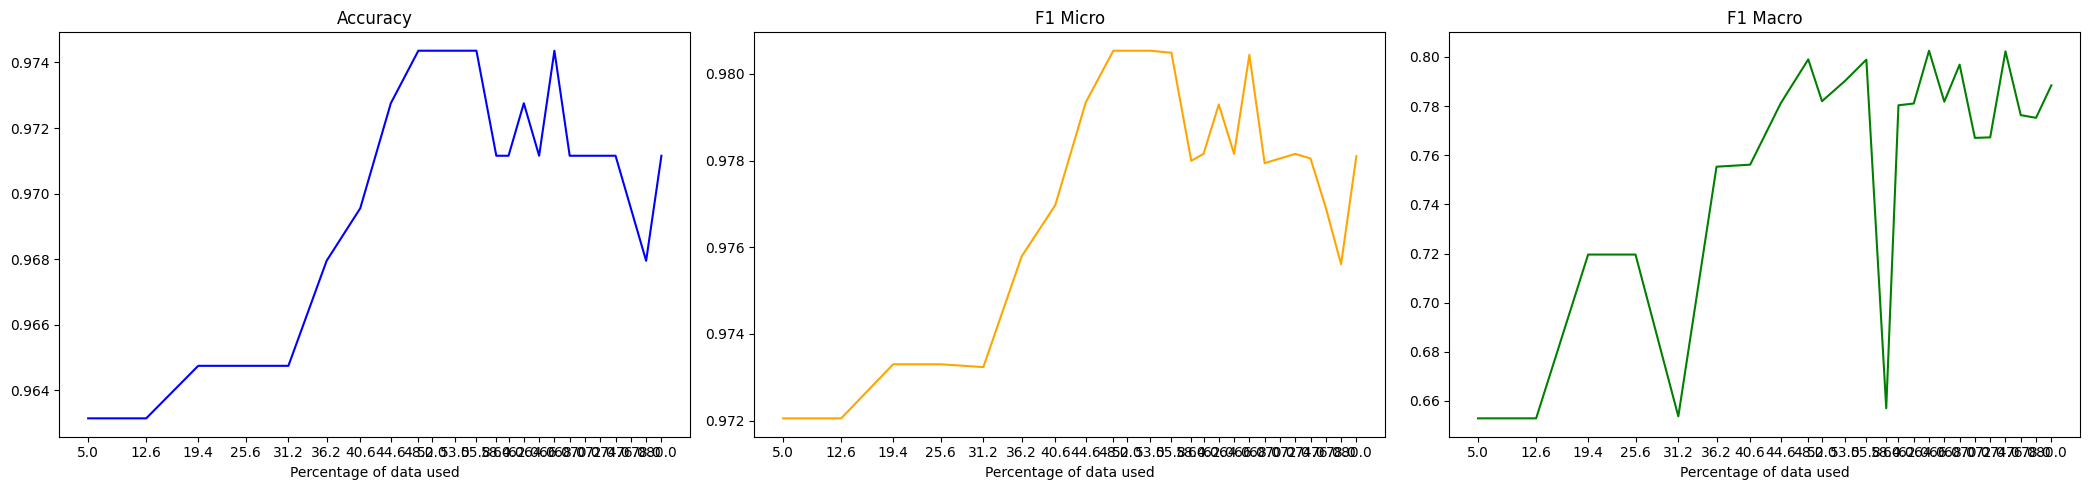

In [21]:
active_learning(seeds[4], 4)